In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [73]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

import the data set into tf_data set

In [83]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "RiceLeafsDisease/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2101 files belonging to 6 classes.


In [122]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'brown_spot',
 'healthy',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [87]:
len(dataset)

66

In [94]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[4 4 1 5 3 1 0 2 1 4 0 0 5 3 0 2 1 0 3 0 5 4 4 0 3 4 0 5 3 1 2 1]


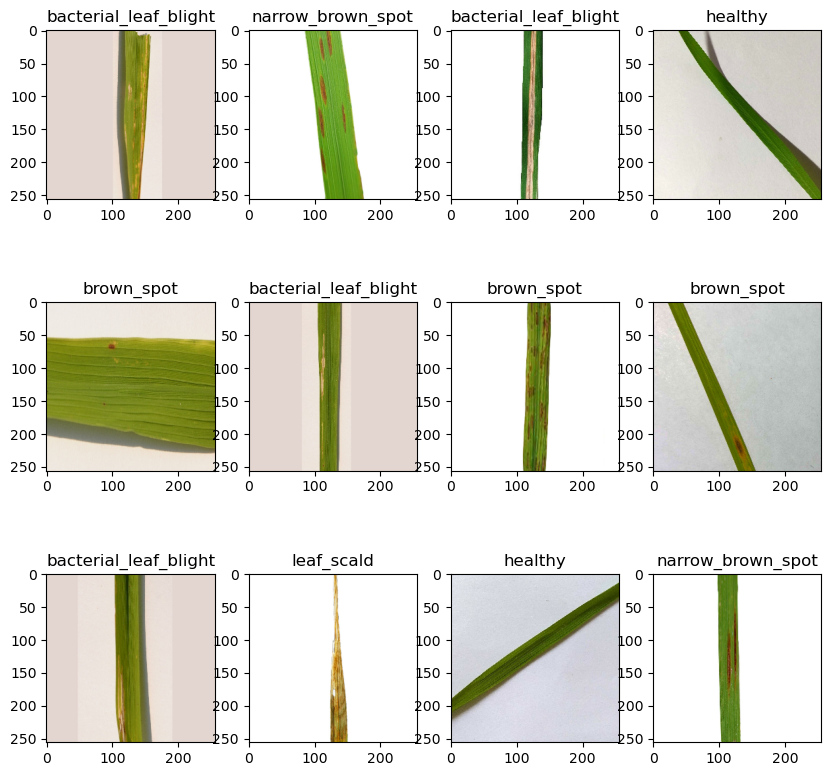

In [134]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
       ax = plt.subplot(3,4,i+1)
       plt.imshow(image_batch[i].numpy().astype("uint8"))
       plt.title(class_names[label_batch[i]])
  

In [136]:
train_size = 0.8
len(dataset)*train_size

52.800000000000004

In [138]:
train_ds = dataset.take(53)
len(train_ds)

53

In [142]:
test_ds = dataset.skip(54)
len(test_ds)


12

In [144]:
val_size = 0.1
len(dataset)*val_size

6.6000000000000005

In [150]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [152]:
test_ds = test_ds.take(6)
len(test_ds)

6

In [154]:
 def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [156]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [158]:
len(train_ds)

52

In [160]:
len(val_ds)

6

In [162]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [165]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize and rescale layer

In [172]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data Augmentation

In [175]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [189]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes = 6
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),])
model.build(input_shape=input_shape)

C:\Users\Lahiru\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [193]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

In [195]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits =False),
    metrics = ['accuracy'])

    

In [199]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step - accuracy: 0.1767 - loss: 1.7906 - val_accuracy: 0.1302 - val_loss: 1.8191
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 716ms/step - accuracy: 0.2435 - loss: 1.7314 - val_accuracy: 0.4479 - val_loss: 1.3882
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 729ms/step - accuracy: 0.3890 - loss: 1.4749 - val_accuracy: 0.4271 - val_loss: 1.3563
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - accuracy: 0.4085 - loss: 1.3794 - val_accuracy: 0.5469 - val_loss: 1.2556
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 736ms/step - accuracy: 0.4861 - loss: 1.2864 - val_accuracy: 0.5521 - val_loss: 1.1093
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 733ms/step - accuracy: 0.5054 - loss: 1.2403 - val_accuracy: 0.6562 - val_loss: 0.9516
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 724ms/step - accuracy: 0.6237 - loss: 0.9899 - val_accuracy: 0.6823 - val_loss: 0.8530
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 749ms/step - accuracy: 0.6600 - loss: 0.9401 - val_accu

In [207]:
import os
model.save("../riceleaves.h5")

In [209]:
history

check for the test data

In [212]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.8838 - loss: 0.2836


Ploting the accuracu and loss curves

In [215]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

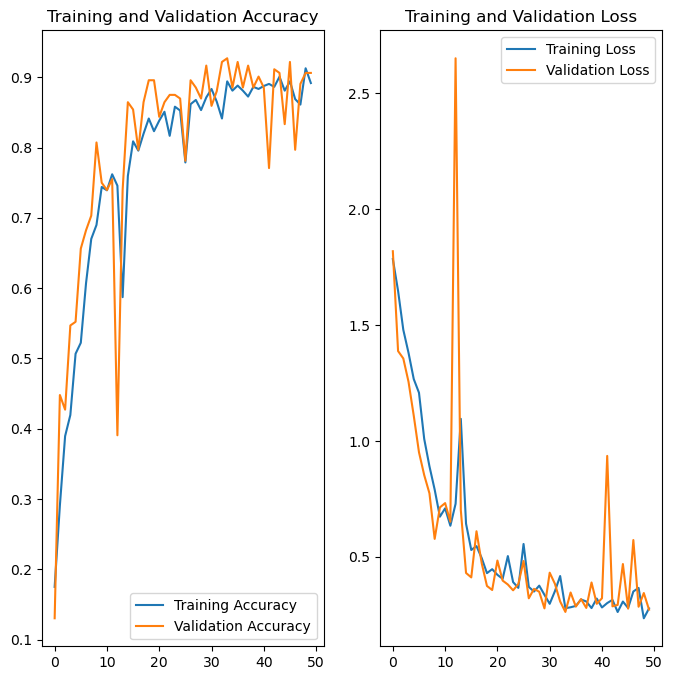

In [219]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sampling

first image to predict
actual label: narrow_brown_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
predicted label: narrow_brown_spot


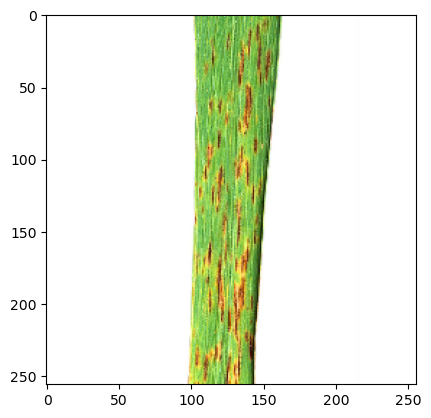

In [221]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a fiunction for inference

In [227]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


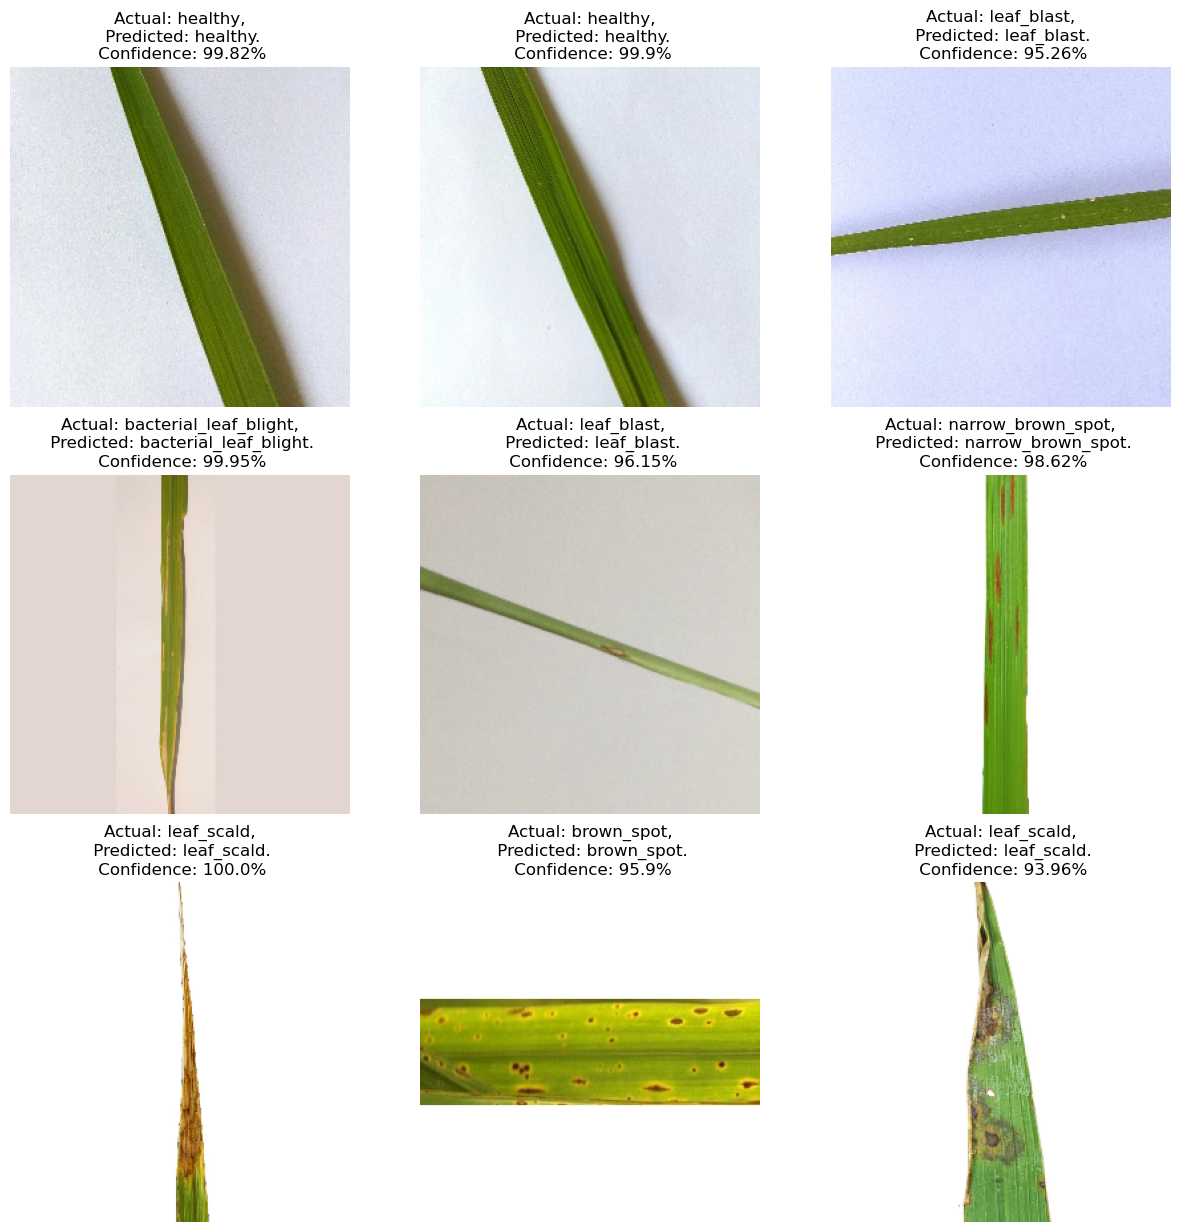

In [229]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [251]:
import os

# Determine the next model version number based on the existing files in the directory.
model_version = max([int(i) for i in os.listdir("models") if i.isdigit()] + [0]) + 1

# Save the model with the determined version number, adding the `.keras` extension.
model.save(f"models/{model_version}.keras")


In [255]:
model.save("../riceleaves.h5")